In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [2]:
no_retract = pd.read_csv('./no_retraction_data_cleaned.csv')
no_retract = no_retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

retract = pd.read_csv('./retraction_data_cleaned.csv')
retract = retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [3]:
total = pd.read_csv('./total_data_cleaned.csv')
total = total.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
total.head()

,doi,year,month,day,volume,issue,journal,title,text,abstract,keywords,publisher,retraction_binary,unpacked_keywords,clean_text,clean_text_lem
0,10.1208/s12249-016-0596-x,2016.0,8.0,10.0,18.0,5.0,AAPS PharmSciTech,Study of the Transformations of Micro/Nano-cry...,‘Polymorphism’ generally referred as the abili...,This study elucidates the physical properties ...,"['monoclinic', 'nano-sized crystals', 'orthorh...",Springer International Publishing,1,"['monoclinic', 'nano-sized', 'crystals', 'orth...",Polymorphism generally referred as the ability...,Polymorphism generally referred a the ability ...
1,10.1021/acscentsci.9b00224,2019.0,5.0,9.0,5.0,6.0,ACS central science,Targeted Protein Internalization and Degradati...,Traditional\ndrug development efforts are focu...,Targeted,[],American Chemical Society,1,[],Traditional drug development efforts are focus...,Traditional drug development effort are focuse...
2,10.1021/acsomega.8b00488,2018.0,6.0,27.0,3.0,6.0,ACS omega,Regulating the Microstructure of Intumescent F...,Intumescent flame retardants\nare now being us...,A compatibilizer,[],American Chemical Society,1,[],Intumescent flame retardants are now being use...,Intumescent flame retardant are now being used...
3,10.1021/acsomega.8b00153,2018.0,6.0,25.0,3.0,6.0,ACS omega,Solid-to-Solid Crystallization of Organic Thin...,Crystal growth process is basic and essential ...,The solid-to-solid crystallization processes o...,[],American Chemical Society,1,[],Crystal growth process is basic and essential ...,Crystal growth process is basic and essential ...
4,10.1107/S1600536811022574,2011.0,6.0,18.0,67.0,NaN,"Acta crystallographica. Section E, Structure r...",Oxonium picrate.,For general background to organic salts of pic...,"The title compound, H3O+·C6H2N3O7",[],International Union of Crystallography,1,[],For general background to organic salts of pic...,For general background to organic salt of picr...


In [9]:
lemmatizer = WordNetLemmatizer()
lem_stopwords = [lemmatizer.lemmatize(i) for i in stopwords.words("english")]

retraction_stopwords = ['wa', 'using', 'et', 'al', 'figure', 'usepackage', 'used', 'fig', 'also', 
                        'ml', 'ha', 'two', 'one', 'may', 'based', 'table', 'however', 'data', 'mm', 'ms']

science_stopwords = ['any','apply','applying','reapplying','given','papers','paper','about',
                     'results','result','real','world','page','article','present','takes',
                     'account', 'previous','work','propose','proposes','proposed','simply','simple',
                     'demonstrate','demonstrated','demonstrates','realworld','datasets','dataset',
                     'provide','important','research','researchers','experiments','experiment','unexpected',
                     'discovering','using','recent','collected','solve','columns','existing','traditional',
                     'final','consider','presented','provides','automatically','extracting','including','help',
                     'helps','explore','illustrate','achieve','better']

In [74]:
X = total['clean_text_lem']
y = total['retraction_binary']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [7]:
y_test.value_counts(normalize=True).mul(100).round(2)

0    69.06
1    30.94
Name: retraction_binary, dtype: float64

In [76]:
vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = stopwords.words("english")+ lem_stopwords + retraction_stopwords + science_stopwords, #stopwords were removed
                            max_features = 20000)

vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(),
                          columns=vectorizer.get_feature_names())

In [70]:
tvec = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, 
                       stop_words = stopwords.words("english")+ lem_stopwords + retraction_stopwords + science_stopwords)

X_train_df = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                  columns=tvec.get_feature_names())
X_test_df = pd.DataFrame(tvec.transform(X_test).toarray(),
                  columns=tvec.get_feature_names())

In [44]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_df, y_train)

DecisionTreeClassifier()

In [45]:
print(f'Score on training set: {dtc.score(X_train_df, y_train)}')
print(f'Score on testing set: {dtc.score(X_test_df, y_test)}')

Score on training set: 0.9927477840451249
Score on testing set: 0.684931506849315


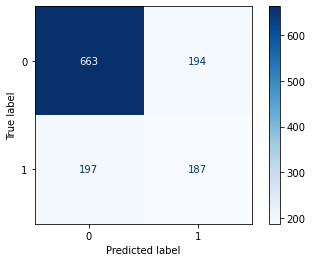

In [46]:
plot_confusion_matrix(dtc, X_test_df, y_test, cmap='Blues', values_format='d');

In [ ]:
#No limit for depth

#20000 features, more stopwords, 99.3% train, 71.1% test, 191 true positive, 193 false negative
#5000 features, more stopwords/bigrams, 99.3% train, 68.5% test, 187 true positive, 197 false negative

In [ ]:
#All max depth = 5

# 20000 features, more stopwords, 77.7% train, 73.6% test, 106 true positive, 278 false negative
# 20000 features, more stopwords/test size = 0.3, 77.7% train, 73.7% test, 130 true positive, 331 false negative

# 5000 features, more stopwords/bi-grams, 78.9% train, 72.7% test, 106 true positive, 278 false negative
# 5000 features, more stopwords/bi-grams/test size = 0.3, 79.7% train, 73.8% test, 135 true positive, 326 false negative

In [58]:
base_tree = DecisionTreeClassifier()

bag = BaggingClassifier(base_estimator=base_tree,
                        bootstrap = True,
                        random_state=42)

bag.fit(X_train_df, y_train)
print(bag.score(X_train_df, y_train))
bag.score(X_test_df, y_test)

0.975825946817083


0.7639000805801772

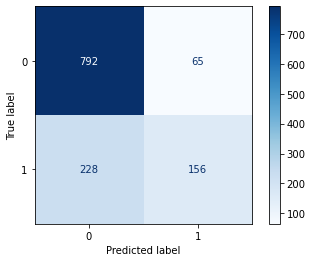

In [59]:
plot_confusion_matrix(bag, X_test_df, y_test, cmap='Blues', values_format='d');

In [ ]:
# 20000 features, more stopwords, 97.7% train, 77.0% test, 167 true positive, 217 false negative
# 5000 features, more stopwords/bi-grams, 97.6% train, 76.4% test, 156 true positive, 228 false negative

In [71]:
rfc = RandomForestClassifier (random_state = 42)

rfc.fit(X_train_df, y_train)
print(rfc.score(X_train_df, y_train))
rfc.score(X_test_df, y_test)

0.9927477840451249


0.7687348912167606

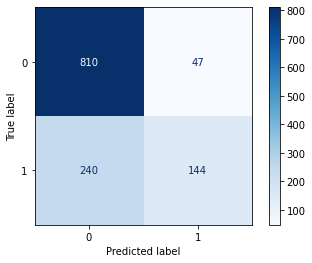

In [72]:
plot_confusion_matrix(rfc, X_test_df, y_test, cmap='Blues', values_format='d');

In [ ]:
# 20000 features, more stopwords, 99.3% train, 77.6% test, 147 true positive, 237 false negative
# 5000 features, more stopwords/bigrams, 99.3% train, 76.9% test, 144 true positive, 240 false negative

In [78]:
base_tree = DecisionTreeClassifier()

bag = BaggingClassifier(base_estimator=base_tree,
                        bootstrap = True,
                        random_state=42)

ada = AdaBoostClassifier(base_estimator=bag,
                         random_state=42)

ada.fit(X_train_df, y_train)
print(ada.score(X_train_df, y_train))
ada.score(X_test_df, y_test)

0.9927477840451249


0.7840451248992748

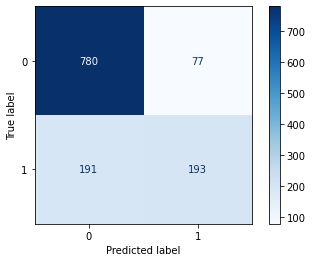

In [80]:
plot_confusion_matrix(ada, X_test_df, y_test, cmap='Blues', values_format='d');